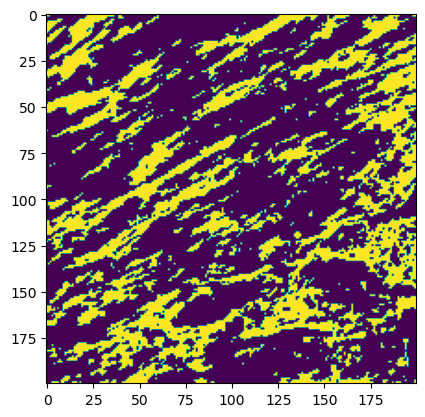

In [1]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(Path("/Users/arstanbek/Projects/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(lambda x: np.array(ast.literal_eval(x)))
df['Tissue size'] = df['Tissue size'].apply(lambda x: ast.literal_eval(x))

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'] >= 0.3) & (df['Density'] <= 0.35) & (df['Elongation'] > 2.5)]
texture = filtered_df["Tissue Matrix"].iloc[0]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2)

plt.figure()
plt.imshow(texture, cmap='viridis')
plt.show()

100%|██████████| 40000/40000 [00:41<00:00, 968.13it/s]


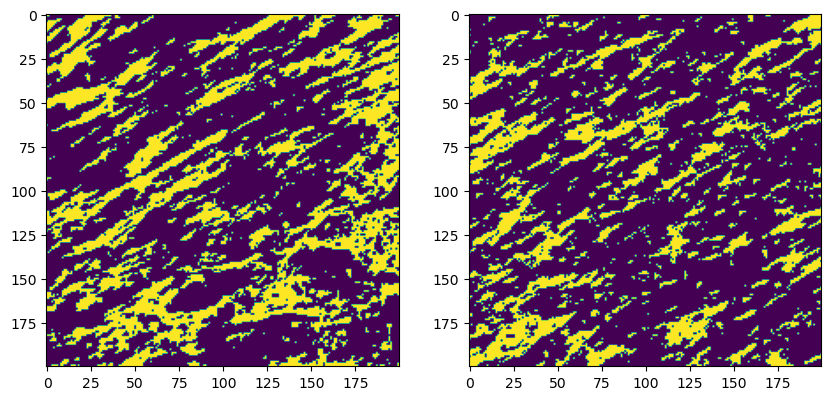

In [2]:
import bitis as bt

texture_ = texture[:, :]
simulation_tex = np.zeros(texture_.shape)
simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=30,
                                 max_template_size=100,
                                 min_template_size=5)

simulation_tex = simulation.run()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(texture_)
ax[1].imshow(simulation_tex)
plt.show()

In [17]:
def copy_with_modifications(texture):
    texture_ = texture.copy()
    texture_[texture_ == 2] = -1
    return texture_


template = texture[:100, :100]
%timeit copy_with_modifications(template)

9.71 µs ± 76.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


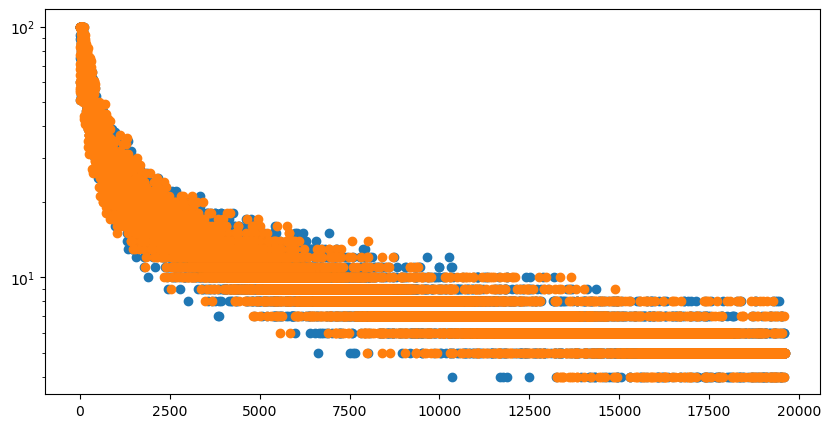

In [5]:
# %matplotlib inline

plt.figure(figsize=(10, 5))
plt.plot(simulation.template_shapes, 'o')
plt.yscale('log')
# plt.xscale('log')
plt.show()

100%|██████████| 19600/19600 [00:45<00:00, 432.20it/s]


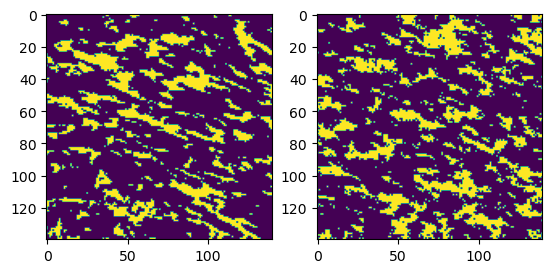

In [3]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import morphology


from bitis.tissue_models.direct_sampling.simulation_path_builder.simulation_random_path_builder import SimulationRandomPathBuilder
from bitis.tissue_models.direct_sampling.simulations.adaptive_simulation import AdaptiveSimulation
from bitis.tissue_models.direct_sampling.training_data_builders.fft_distance_builder import FFTDistanceBuilder



df = pd.read_csv(Path("/Users/arstanbek/Projects/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(lambda x: np.array(ast.literal_eval(x)))
df['Tissue size'] = df['Tissue size'].apply(lambda x: ast.literal_eval(x))

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'] >= 0.2) &
                 (df['Density'] <= 0.25) &
                 (df['Elongation'] > 2.5)]
texture = filtered_df["Tissue Matrix"].iloc[0]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2)

# mask = morphology.remove_small_objects(texture == 2, min_size=5, connectivity=1)
# texture = np.zeros_like(texture)
# texture[mask] = 2
# texture[~mask] = 1

simulation_size = texture.shape

template_size = np.array([13, 13])

precondition_matrix = np.zeros(simulation_size)

simulation_path_builder = SimulationRandomPathBuilder(template_size, simulation_size)

mask = np.random.random(texture.shape) < 0.01
precondition_matrix[mask] = texture[mask]

simulation = AdaptiveSimulation(precondition_matrix,
                                texture,
                                simulation_path_builder,
                                FFTDistanceBuilder(texture, 0.0))

simulated_tex = simulation.run()

# mask = morphology.remove_small_objects(simulated_tex == 2, min_size=5, connectivity=1)
# simulated_tex = np.zeros_like(simulated_tex)
# simulated_tex[mask] = 2
# simulated_tex[~mask] = 1

fig, ax = plt.subplots(1, 2)

ax[0].imshow(texture)
ax[1].imshow(simulated_tex)
plt.show()

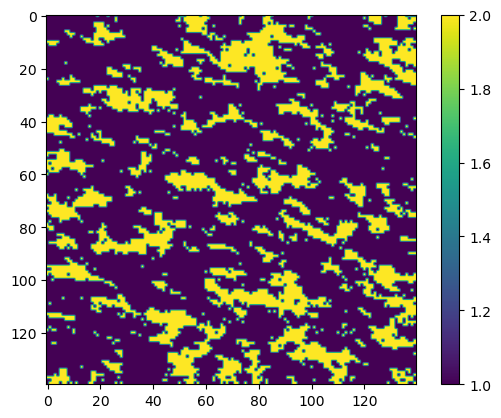

In [4]:
simulated_tex[simulated_tex == -1] = 2
plt.figure()
plt.imshow(simulated_tex)
plt.colorbar()
plt.show()

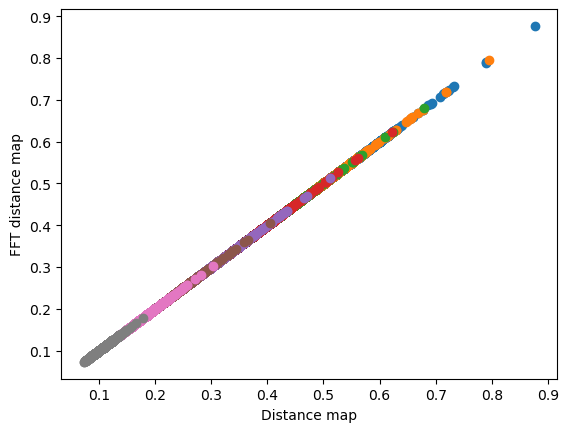

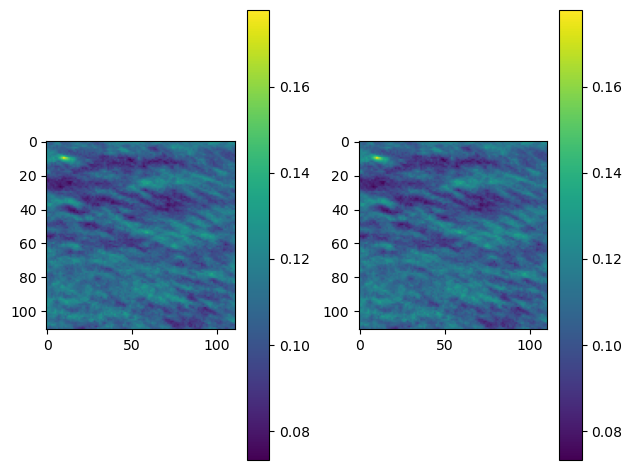

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

from bitis.tissue_models.direct_sampling.training_data_builders.fft_distance_builder import FFTDistanceBuilder
from bitis.tissue_models.direct_sampling.template_matching.distance_map.distance_map_builder import DistanceBuilder

df = pd.read_csv(Path("/Users/arstanbek/Projects/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(lambda x: np.array(ast.literal_eval(x)))
df['Tissue size'] = df['Tissue size'].apply(lambda x: ast.literal_eval(x))

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'] >= 0.2) &
                 (df['Density'] <= 0.25) &
                 (df['Elongation'] > 2.5)]
texture = filtered_df["Tissue Matrix"].iloc[0]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2)

plt.figure()

for d in np.arange(0.1, 0.9, 0.1):
    template = texture[10:40, 10:40].copy()
    template[np.random.random(template.shape) < d] = 0

    dist_builder = DistanceBuilder(texture)
    d_map = dist_builder.calc_distance_map(texture, template)
    # print(dist_builder.calc_min_distance_idx(template))

    fft_dist_builder = FFTDistanceBuilder(texture, 0.0)
    fft_d_map = fft_dist_builder.calc_distance_map(texture, template)
    # print(fft_dist_builder.calc_min_distance_idx(template))

    plt.scatter(d_map.flatten(), fft_d_map.flatten())
plt.xlabel("Distance map")
plt.ylabel("FFT distance map")
plt.show()

fig, axs = plt.subplots(1, 2)
d_im = axs[0].imshow(d_map)
fig.colorbar(d_im, ax=axs[0])
fft_d_im = axs[1].imshow(fft_d_map)
fig.colorbar(fft_d_im, ax=axs[1])
plt.tight_layout()
plt.show()

In [50]:
import numpy as np
from scipy import spatial

coords = np.argwhere(texture[:100, :100] != 0)
coord = np.array([20, 20])
max_size = 10
max_distance = 50
#  Find the nearest max_size already labeled pixels

def find_nearest(coords, coord, max_size, max_distance):
    tree = spatial.KDTree(coords)
    d, ind = tree.query(coord, k=max_size, distance_upper_bound=max_distance)
    return ind[d < np.inf]


%timeit spatial.KDTree(coords)
%timeit find_nearest(coords, coord, max_size, max_distance)

1.49 ms ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.51 ms ± 9.14 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


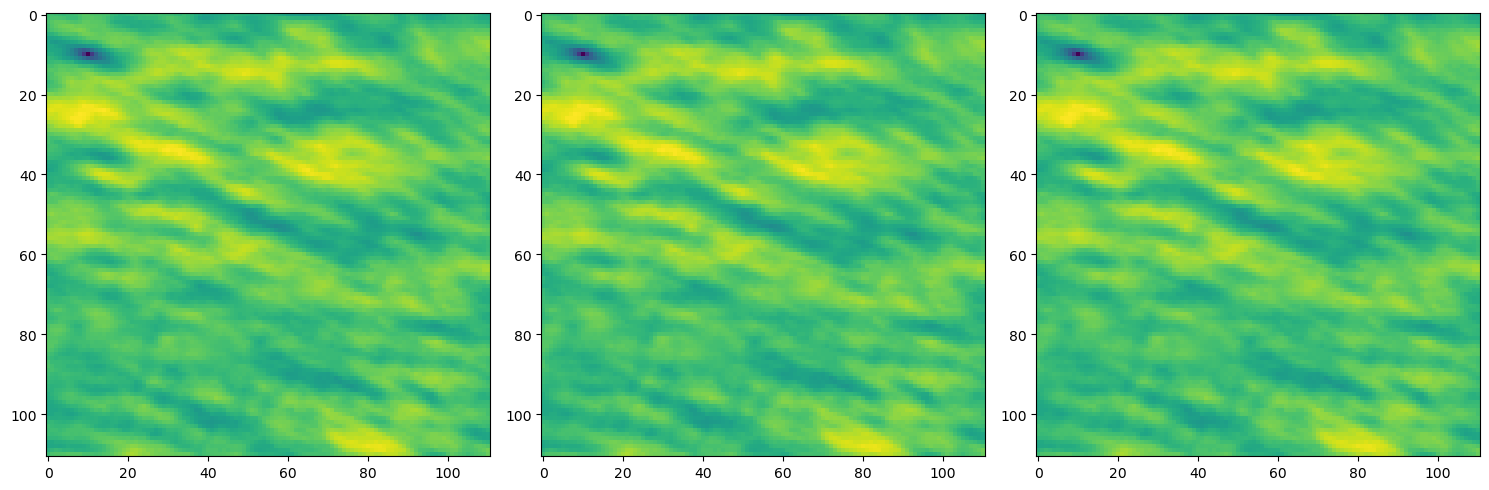

In [8]:
import numpy as np
from scipy import signal, fft


class SingleImageMatching:
    """
    Attributes:
        training_image (numpy.ndarray): The training image.
        min_distance (float): The minimum distance threshold. If the minimum
            distance is more than this value, a random pixel is returned.
    """
    def __init__(self, training_image, min_distance=1.0):
        self.training_image = training_image
        self.min_distance = min_distance

    def run(self, template, coord_on_template):
        """Calculate the minimum distance index and return the corresponding
        pixel value.

        Args:
            template (numpy.ndarray): The template.

        Returns:
            int: The pixel value.
        """
        if np.count_nonzero(template) == 0:
            return self.random_pixel()

        return self.best_matching_pixel(template, coord_on_template)

    def best_matching_pixel(self, template, coord_on_template):
        """Calculate the minimum distance index. If minimum distance is less
        than the distance threshold, return a random index.

        Args:
            template (numpy.ndarray): The template.
        """
        distance_map = self.calc_distance_map(template)

        threshold = min(distance_map.min(), self.min_distance)
        inds = np.flatnonzero(distance_map <= threshold)

        if len(inds) == 0:
            return self.random_pixel()

        random_ind = np.random.choice(inds)
        coord = np.unravel_index(random_ind, distance_map.shape)

        coord = [c + t for c, t in zip(coord, coord_on_template)]
        return self.training_image[*coord]

    def random_pixel(self):
        """Return a random pixel from the training image."""
        coord = [np.random.randint(i) for i in self.training_image.shape]
        return self.training_image[*coord]

    def calc_distance_map(self, template):
        """Calculate the distance map between the training image and
        the template.

        Args:
            image (numpy.ndarray): The training image.
            template (numpy.ndarray): The template.
        """
        dist_fibr = signal.correlate((self.training_image == 2).astype(float),
                                     (template == 2).astype(float),
                                     mode='valid', method='fft')
        dist_myo = signal.correlate((self.training_image == 1).astype(float),
                                    (template == 1).astype(float),
                                    mode='valid', method='fft')
        matching_pixels = dist_fibr + dist_myo
        total_pixels = np.count_nonzero(template)
        return 1 - matching_pixels / total_pixels


import numpy as np
from scipy import signal, fft


class SingleImageMatchingFFT1:
    """
    Attributes:
        training_image (numpy.ndarray): The training image.
        min_distance (float): The minimum distance threshold. If the minimum
            distance is more than this value, a random pixel is returned.
    """
    def __init__(self, training_image, min_distance=1.0):
        self.training_image = training_image
        self.min_distance = min_distance

    @property
    def training_image(self):
        return self._original_image

    @training_image.setter
    def training_image(self, image):
        self._original_image = image
        image = image.copy().astype(np.float32)
        image[image == 2] = -1
        # self._normalized_image = image.astype(np.float32)
        self.fft_shape = [fft.next_fast_len(s, True) for s in image.shape]
        self.fft_image = fft.rfftn(image, s=self.fft_shape)

    def run(self, template, coord_on_template):
        """Calculate the minimum distance index and return the corresponding
        pixel value.

        Args:
            template (numpy.ndarray): The template.

        Returns:
            int: The pixel value.
        """
        if np.count_nonzero(template) == 0:
            return self.random_pixel()

        return self.best_matching_pixel(template, coord_on_template)

    def best_matching_pixel(self, template, coord_on_template):
        """Calculate the minimum distance index. If minimum distance is less
        than the distance threshold, return a random index.

        Args:
            template (numpy.ndarray): The template.
        """
        distance_map = self.calc_distance_map(template)

        threshold = min(distance_map.min(), self.min_distance)
        inds = np.flatnonzero(distance_map <= threshold)

        if len(inds) == 0:
            return self.random_pixel()

        random_ind = np.random.choice(inds)
        coord = np.unravel_index(random_ind, distance_map.shape)

        coord = [c + t for c, t in zip(coord, coord_on_template)]
        return self.training_image[*coord]

    def random_pixel(self):
        """Return a random pixel from the training image."""
        coord = [np.random.randint(i) for i in self.training_image.shape]
        return self.training_image[*coord]

    def calc_distance_map(self, template):
        """Calculate the distance map between the training image and
        the template.

        Args:
            template (numpy.ndarray): The template.
        """
        template = template.copy()
        template[template == 2] = -1
        fft_template = fft.rfftn(template, s=self.fft_shape).conj()
        matching_pixels = fft.irfftn(self.fft_image * fft_template).real

        i_max = self.training_image.shape[0] - template.shape[0] + 1
        j_max = self.training_image.shape[1] - template.shape[1] + 1
        matching_pixels = matching_pixels[:i_max, :j_max]

        known_pixels = np.count_nonzero(template != 0)
        matching_pixels = 0.5 * (matching_pixels + known_pixels)
        return 1 - matching_pixels / known_pixels


class SingleImageMatchingFFT2:
    """
    Attributes:
        training_image (numpy.ndarray): The training image.
        min_distance (float): The minimum distance threshold. If the minimum
            distance is more than this value, a random pixel is returned.
    """
    def __init__(self, training_image, min_distance=1.0):
        self.training_image = training_image
        self.min_distance = min_distance

    @property
    def training_image(self):
        return self._original_image

    @training_image.setter
    def training_image(self, image):
        self._original_image = image
        image = image.copy()
        image[image == 2] = -1
        self._normalized_image = image.astype(np.float32)

    def run(self, template, coord_on_template):
        """Calculate the minimum distance index and return the corresponding
        pixel value.

        Args:
            template (numpy.ndarray): The template.

        Returns:
            int: The pixel value.
        """
        if np.count_nonzero(template) == 0:
            return self.random_pixel()

        return self.best_matching_pixel(template, coord_on_template)

    def best_matching_pixel(self, template, coord_on_template):
        """Calculate the minimum distance index. If minimum distance is less
        than the distance threshold, return a random index.

        Args:
            template (numpy.ndarray): The template.
        """
        distance_map = self.calc_distance_map(template)

        threshold = min(distance_map.min(), self.min_distance)
        inds = np.flatnonzero(distance_map <= threshold)

        if len(inds) == 0:
            return self.random_pixel()

        random_ind = np.random.choice(inds)
        coord = np.unravel_index(random_ind, distance_map.shape)

        coord = [c + t for c, t in zip(coord, coord_on_template)]
        return self.training_image[*coord]

    def random_pixel(self):
        """Return a random pixel from the training image."""
        coord = [np.random.randint(i) for i in self.training_image.shape]
        return self.training_image[*coord]

    def calc_distance_map(self, template):
        """Calculate the distance map between the training image and
        the template.

        Args:
            image (numpy.ndarray): The training image.
            template (numpy.ndarray): The template.
        """
        template = template.copy()
        template[template == 2] = -1.
        matching_pixels = signal.correlate(self._normalized_image,
                                           template.astype(np.float32),
                                           mode='valid', method='fft')
        known_pixels = np.count_nonzero(template != 0)
        matching_pixels = 0.5 * (matching_pixels + known_pixels)
        return 1 - matching_pixels / known_pixels
    

template_matching = SingleImageMatching(texture)
template_matching_fft1 = SingleImageMatchingFFT1(texture)
template_matching_fft2 = SingleImageMatchingFFT2(texture)

template = texture[10:40, 10:40].copy()
coord_on_template = [15, 15]

res = template_matching.calc_distance_map(template)
res_fft1 = template_matching_fft1.calc_distance_map(template)
res_fft2 = template_matching_fft2.calc_distance_map(template)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(res)
axs[1].imshow(res_fft1)
axs[2].imshow(res_fft2)
plt.tight_layout()
plt.show()


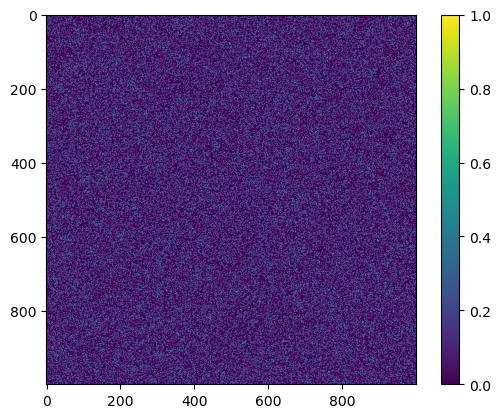

In [66]:
def find_template(texture, min_size, max_size, max_num, i, j):
    for d_i in range(max_size, min_size):
        i_min = max(0, i - d_i)
        i_max = min(texture.shape[0], i + d_i)
        j_min = max(0, j - d_i)
        j_max = min(texture.shape[1], j + d_i)

        res = texture[i_min: i_max, j_min: j_max]
        if np.count_nonzero(res) <= max_num:
            return texture[i_min: i_max, j_min: j_max]
        
        return texture[i_min: i_max, j_min: j_max]
    

def find_all_templates(texture, coords, min_size, max_size, max_num):
    res = []
    for i, j in coords:
        res = find_template(texture, min_size, max_size, max_num, i, j)
        texture[i, j] = 1
    return res


max_size = 10
max_distance = 50

image = np.zeros((1000, 1000))

coords = np.argwhere(image == 0)
np.random.shuffle(coords)

res = find_template(image, 3, 50, 10, 50, 50)
res = find_all_templates(image, coords[:100_000], 3, 50, 10)


plt.imshow(image)
plt.colorbar()
plt.show()

In [ ]:
import numpy as np


def slice_array(x, mins, maxs):
    return x[tuple(slice(min_, max_) for min_, max_ in zip(mins, maxs))]    


mins = [0, 20, 30]
maxs = [100, 120, 130]

x = np.zeros((500, 500, 500))

%timeit slice_array(x, mins, maxs)
%timeit x[mins[0]:maxs[0], mins[1]:maxs[1], mins[2]:maxs[2]]


740 ns ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
216 ns ± 10.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [15]:
%timeit np.argwhere(x == 0)
%timeit np.count_nonzero(x == 0)

1.51 s ± 76.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.5 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
x = np.random.random((1000, 1000))

def select_index(x):
    return np.unravel_index(np.flatnonzero(x < 0.5), x.shape)

# print(np.unravel_index(np.flatnonzero(x < 0.5), x.shape))
# print(np.where(x < 0.5))
# print(np.argwhere(x < 0.5))

%timeit np.max(x)
%timeit np.argmax(x < 0.5)
%timeit np.unravel_index(np.flatnonzero(x < 0.5), x.shape)
%timeit np.where(x < 0.5)
%timeit np.argwhere(x < 0.5)

109 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
108 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.35 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.95 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.31 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
import numpy as np

t_s = 13
x_s = 16129

x = np.arange(x_s * t_s * t_s).reshape(x_s, t_s, t_s).astype(np.float32)
t = np.arange(t_s * t_s).reshape(t_s, t_s).astype(np.float32)
t[t < 50] = 0

print(x.shape, t.shape)
d = (x == t[None, ...]).sum(axis=tuple(range(1, x.ndim)))

%timeit (x == t[None, ...]).sum(axis=tuple(range(1, x.ndim)))
%timeit np.all(d < 100)
%timeit np.flatnonzero(d < 100)
%timeit np.random.permutation(len(d))
%timeit np.argmax(d < 100)
%timeit np.argmin(d < 100)


(2000, 10, 10) (10, 10)
101 µs ± 980 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.16 µs ± 102 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.12 µs ± 97.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
18.4 µs ± 20.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.5 µs ± 23.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.55 µs ± 12.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
